<a href="https://colab.research.google.com/github/vijaygwu/SEAS8525/blob/main/Class_6_MultiModalLLMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install Pillow requests

In [ ]:
import requests
from PIL import Image
from io import BytesIO

In [ ]:
from urllib.request import urlopen




In [ ]:
# URL of the image
url = 'https://cdn.pixabay.com/photo/2021/01/17/07/35/dog-5924174_1280.jpg'

In [ ]:
# Send a GET request to the URL
response = requests.get(url)
image = Image.open(BytesIO(response.content))




In [ ]:
image.show()

In [ ]:
caption = "a puppy playing in the snow"

In [ ]:
from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel

model_id = "openai/clip-vit-base-patch32"

# Load a tokenizer to preprocess the text
tokenizer = CLIPTokenizerFast.from_pretrained(model_id)

# Load a processor to preprocess the images
processor = CLIPProcessor.from_pretrained(model_id)

# Main model for generating text and image embeddings
model = CLIPModel.from_pretrained(model_id)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [ ]:
inputs = tokenizer(caption, return_tensors="pt"); inputs

{'input_ids': tensor([[49406,   320,  6829,  1629,   530,   518,  2583, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}

In [ ]:
tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

['<|startoftext|>',
 'a</w>',
 'puppy</w>',
 'playing</w>',
 'in</w>',
 'the</w>',
 'snow</w>',
 '<|endoftext|>']

In [ ]:
# Create a text embedding
text_embedding = model.get_text_features(**inputs)
text_embedding.shape

torch.Size([1, 512])

In [ ]:
# Preprocess image
processed_image = processor(text=None, images=image, return_tensors='pt')['pixel_values']
processed_image.shape


torch.Size([1, 3, 224, 224])

(-0.5, 223.5, 223.5, -0.5)

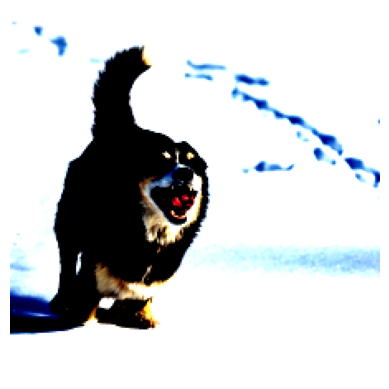

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Prepare image for visualization
img = processed_image.squeeze(0).T
img = np.einsum('ijk->jik', img)

# Visualize preprocessed image
plt.imshow(img)
plt.axis('off')

In [ ]:
# Create the image embedding
image_embedding = model.get_image_features(processed_image)
image_embedding.shape

torch.Size([1, 512])

In [ ]:
# Calculate the probability of the text belonging to the image
text_probs = (100.0 * image_embedding @ text_embedding.T).softmax(dim=-1)
text_probs

tensor([[1.]], grad_fn=<SoftmaxBackward0>)

In [ ]:
# Normalize the embeddings
text_embedding /= text_embedding.norm(dim=-1, keepdim=True)
image_embedding /= image_embedding.norm(dim=-1, keepdim=True)

# Calculate their similarity
text_embedding = text_embedding.detach().cpu().numpy()
image_embedding = image_embedding.detach().cpu().numpy()
score = np.dot(text_embedding, image_embedding.T)
score

array([[0.2952432]], dtype=float32)

In [ ]:
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 3.2 MB/s eta 0:00:00


In [ ]:


from sentence_transformers import SentenceTransformer, util

# Load SBERT-compatible CLIP model
model = SentenceTransformer('clip-ViT-B-32')

# Encode the images
image_embeddings = model.encode(image)

# Encode the captions
text_embeddings = model.encode(caption)

#Compute cosine similarities
sim_matrix = util.cos_sim(image_embeddings, text_embeddings)
print(sim_matrix)

tensor([[0.2952]])


In [ ]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration
import torch

# Load processor and main model
processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16)

# Send the model to GPU to speed up inference
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/6.96k [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/122k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/5.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Blip2ForConditionalGeneration(
  (vision_model): Blip2VisionModel(
    (embeddings): Blip2VisionEmbeddings(
      (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (encoder): Blip2Encoder(
      (layers): ModuleList(
        (0-38): 39 x Blip2EncoderLayer(
          (self_attn): Blip2Attention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=1408, out_features=4224, bias=True)
            (projection): Linear(in_features=1408, out_features=1408, bias=True)
          )
          (layer_norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
          (mlp): Blip2MLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1408, out_features=6144, bias=True)
            (fc2): Linear(in_features=6144, out_features=1408, bias=True)
          )
          (layer_norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((

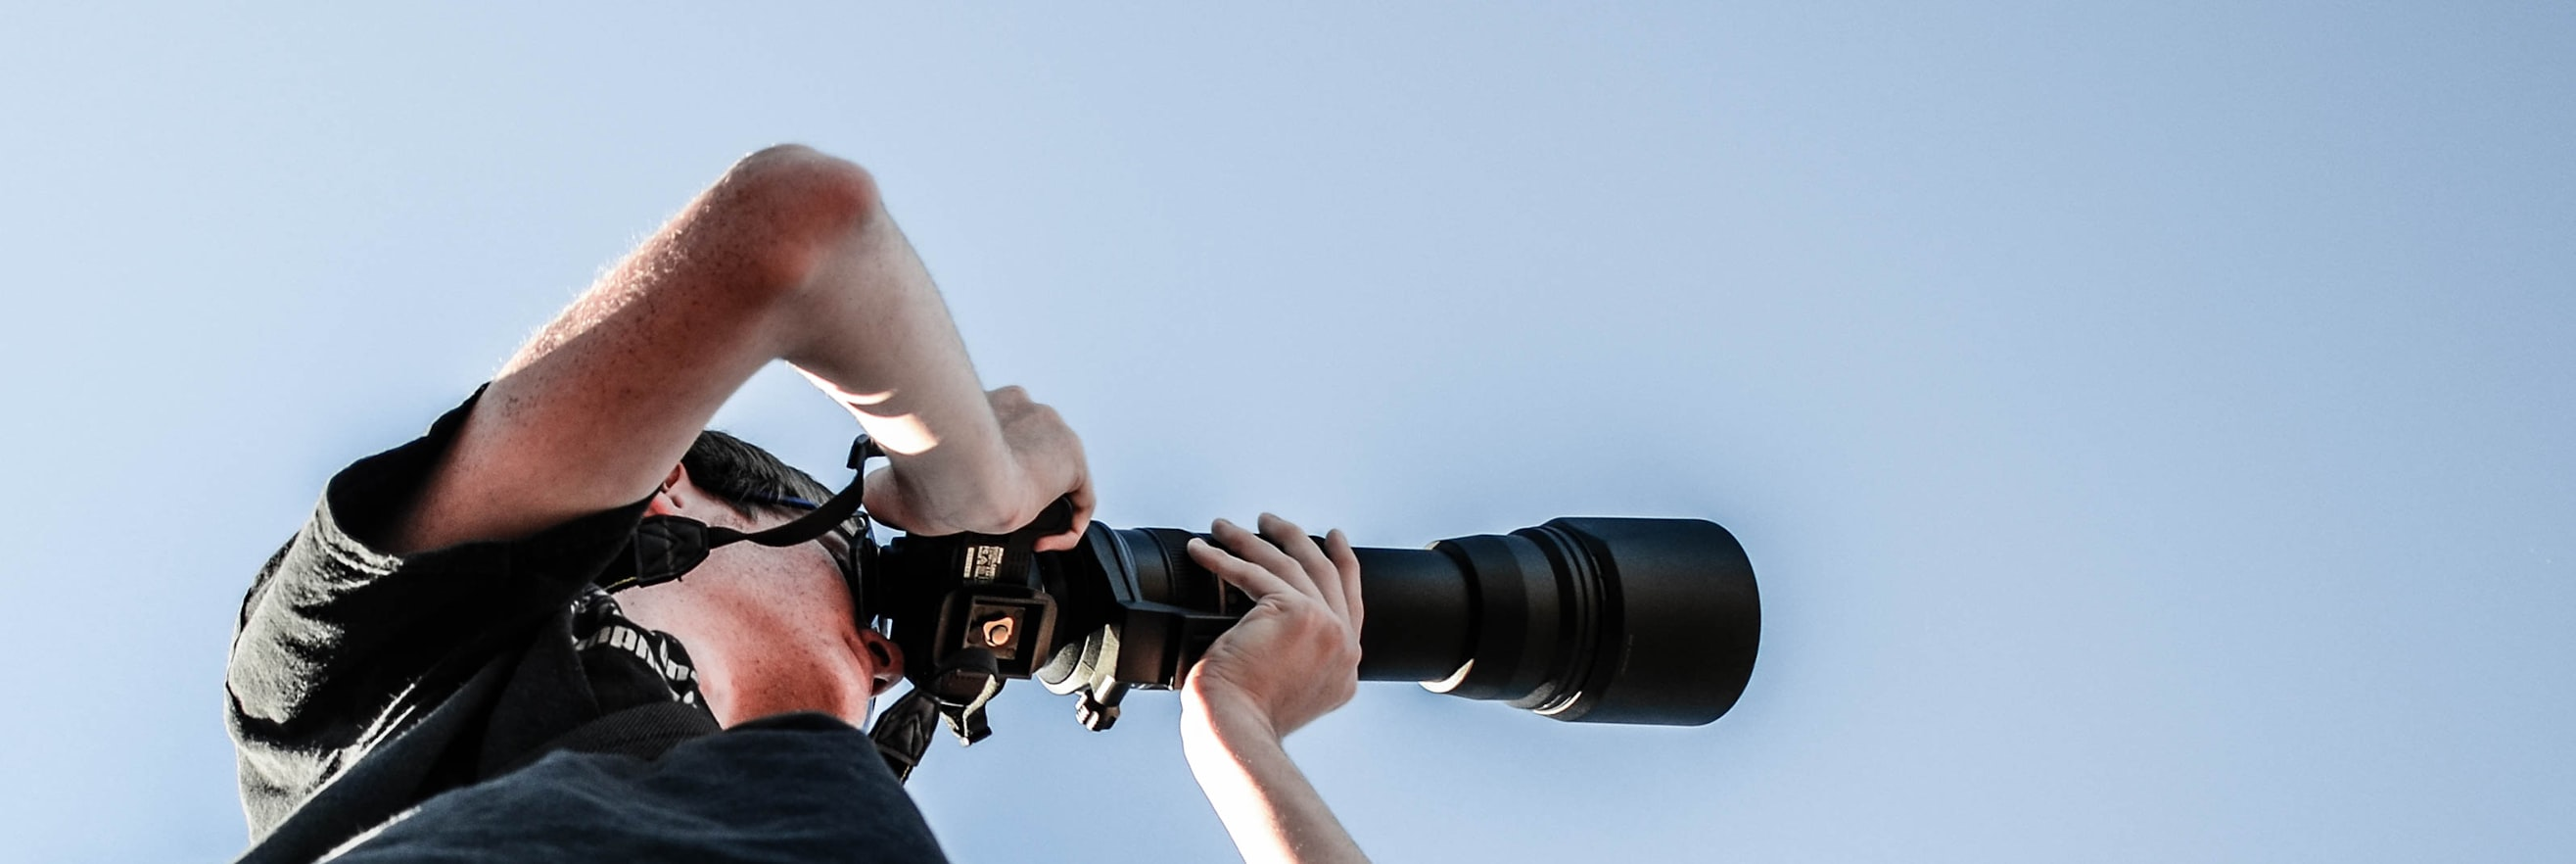

In [ ]:
from urllib.request import urlopen
from PIL import Image

# Load a wide image
link = "https://images.unsplash.com/photo-1524602010760-6eb67b3c63a0?ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&w=2631&q=80"
image = Image.open(urlopen(link)).convert("RGB")
image

In [ ]:
import numpy as np

np.array(image).shape

(882, 2631, 3)

In [ ]:
inputs = processor(image, return_tensors="pt").to(device, torch.float16)
inputs["pixel_values"].shape

torch.Size([1, 3, 224, 224])

In [ ]:
processor.tokenizer

GPT2TokenizerFast(name_or_path='Salesforce/blip2-opt-2.7b', vocab_size=50265, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '</s>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}

In [ ]:
# Preprocess the text
text = "Her vocalization was remarkably melodic"
token_ids = processor(image, text=text, return_tensors="pt").to(device, torch.float16)["input_ids"][0]

# Convert input ids back to tokens
tokens = processor.tokenizer.convert_ids_to_tokens(token_ids)

In [ ]:
inputs = processor(image, return_tensors="pt").to(device, torch.float16)
inputs["pixel_values"].shape



torch.Size([1, 3, 224, 224])

In [ ]:
processor.tokenizer

GPT2TokenizerFast(name_or_path='Salesforce/blip2-opt-2.7b', vocab_size=50265, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '</s>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}

In [ ]:
# Preprocess the text
text = "Her vocalization was remarkably melodic"
token_ids = processor(image, text=text, return_tensors="pt").to(device, torch.float16)["input_ids"][0]

# Convert input ids back to tokens
tokens = processor.tokenizer.convert_ids_to_tokens(token_ids)

In [ ]:
tokens = [token.replace("Ġ", "_") for token in tokens]
tokens

['</s>', 'Her', '_vocal', 'ization', '_was', '_remarkably', '_mel', 'odic']

In [ ]:
import requests
from PIL import Image
from io import BytesIO

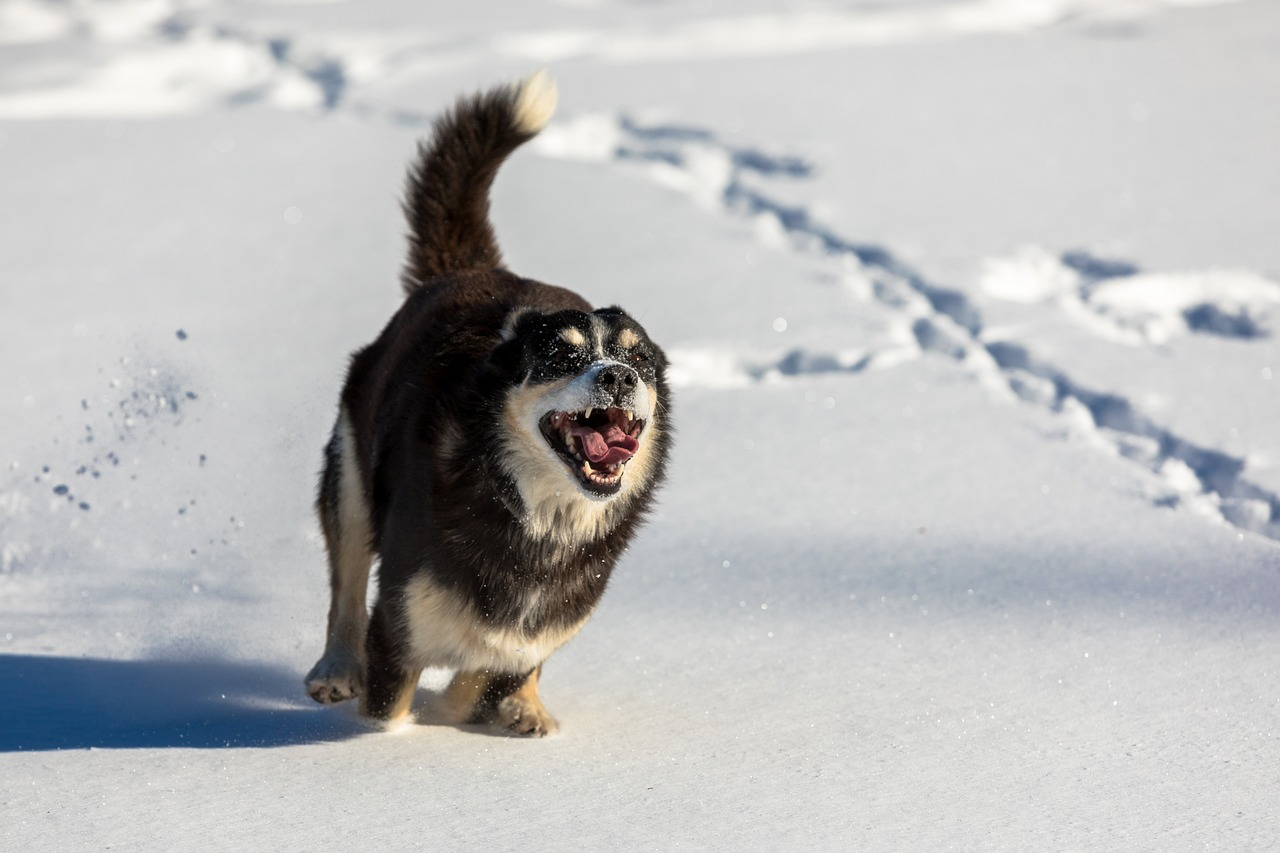

In [ ]:


 # URL of the image
url = 'https://cdn.pixabay.com/photo/2021/01/17/07/35/dog-5924174_1280.jpg'

# Send a GET request to the URL
response = requests.get(url)
image = Image.open(BytesIO(response.content)).convert("RGB")


# Convert an image into inputs and preprocess it
inputs = processor(image, return_tensors="pt").to(device, torch.float16)
image

In [ ]:
# Generate token ids using the full BLIP-2 model
generated_ids = model.generate(**inputs, max_new_tokens=20)

# Convert the token ids to text
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

In [ ]:
print(generated_text)

a dog running in the snow with its mouth open


In [ ]:
# Load rorschach image
url = "https://upload.wikimedia.org/wikipedia/commons/7/70/Rorschach_blot_01.jpg"
image = Image.open(urlopen(url)).convert("RGB")

# Generate caption
inputs = processor(image, return_tensors="pt").to(device, torch.float16)
generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

In [ ]:
 print(generated_text)

a black and white ink drawing of a bat


In [ ]:
# URL of the image
url = "https://upload.wikimedia.org/wikipedia/commons/7/70/Rorschach_blot_01.jpg"

# Send a GET request to the URL
response = requests.get(url)
image = Image.open(BytesIO(response.content)).convert("RGB")


inputs = processor(image, return_tensors="pt").to(device, torch.float16)

In [ ]:
# Visual Question Answering
prompt = "Question: Write down what you see in this picture. Answer:"

# Process both the image and the prompt
inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)

# Generate text
generated_ids = model.generate(**inputs, max_new_tokens=30)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

In [ ]:
print(generated_text)

The image is a black and white ink blot


In [ ]:
from IPython.display import HTML, display
import ipywidgets as widgets

def text_eventhandler(*args):
  question = args[0]["new"]
  if question:
    args[0]["owner"].value = ""

    # Create prompt
    if not memory:
      prompt = " Question: " + question + " Answer:"
    else:
      template = "Question: {} Answer: {}."
      prompt = " ".join([template.format(memory[i][0], memory[i][1]) for i in range(len(memory))]) + " Question: " + question + " Answer:"

    # Generate text
    inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)
    generated_ids = model.generate(**inputs, max_new_tokens=100)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip().split("Question")[0]

    # Update memory
    memory.append((question, generated_text))

    # Assign to output
    output.append_display_data(HTML("<b>USER:</b> " + question))
    output.append_display_data(HTML("<b>BLIP-2:</b> " + generated_text))
    output.append_display_data(HTML("<br>"))

# Prepare widgets
in_text = widgets.Text()
in_text.continuous_update = False
in_text.observe(text_eventhandler, "value")
output = widgets.Output()
memory = []

# Display chat box
display(
    widgets.VBox(
        children=[output, in_text],
        layout=widgets.Layout(display="inline-flex", flex_flow="column-reverse"),
    )
)